In [1]:

from data import load_all_data
dataset = load_all_data()

print(dataset)

/home/lrq619/anaconda3/envs/stat/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/lrq619/anaconda3/envs/stat/lib/python3.8/site-packages/huggingface_hub/utils/_runtime.py:185: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


number of dates: 2868
The dataset has 70 features, each feature has 2868 data points
DatasetDict({
    train: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 70
    })
    test: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 70
    })
    validation: Dataset({
        features: ['start', 'target', 'feat_static_cat', 'feat_dynamic_real', 'item_id'],
        num_rows: 70
    })
})


In [2]:
freq = "1D"
prediction_length = 365

train_dataset = dataset["train"]
test_dataset = dataset["test"]

In [3]:

from functools import lru_cache

import pandas as pd
import numpy as np

@lru_cache(10_000)
def convert_to_pandas_period(date, freq):
    return pd.Period(date, freq)


def transform_start_field(batch, freq):
    batch["start"] = [convert_to_pandas_period(date, freq) for date in batch["start"]]
    return batch

In [4]:

from functools import partial

train_dataset.set_transform(partial(transform_start_field, freq=freq))
test_dataset.set_transform(partial(transform_start_field, freq=freq))


from gluonts.dataset.multivariate_grouper import MultivariateGrouper
num_of_variates = len(train_dataset)

train_grouper = MultivariateGrouper(max_target_dim=num_of_variates)
test_grouper = MultivariateGrouper(
    max_target_dim=num_of_variates,
    num_test_dates=len(test_dataset) // num_of_variates, # number of rolling test windows
)

multi_variate_train_dataset = train_grouper(train_dataset)
multi_variate_test_dataset = test_grouper(test_dataset)
print(multi_variate_train_dataset[0]["target"])


[[1.624695e+00 1.625250e+00 1.608234e+00 ... 1.389043e+00 1.393146e+00
  1.398993e+00]
 [1.230900e+00 1.232500e+00 1.234300e+00 ... 1.167260e+00 1.168100e+00
  1.167290e+00]
 [5.000000e-01 5.000000e-01 5.000000e-01 ... 1.000000e-01 1.000000e-01
  1.000000e-01]
 ...
 [0.000000e+00 0.000000e+00 0.000000e+00 ... 5.863020e+05 5.863020e+05
  6.007500e+05]
 [3.290200e+02 3.668200e+02 2.879000e+02 ... 1.953300e+02 2.752400e+02
  1.067100e+02]
 [1.005860e+03 5.270200e+02 4.190400e+02 ... 4.525000e+02 5.484400e+02
  3.160400e+02]]


In [5]:

from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[1, 2, 3, 4, 5, 6, 7, 8, 13, 14, 15, 20, 21, 22, 27, 28, 29, 30, 31, 56, 84, 363, 364, 365, 727, 728, 729, 1091, 1092, 1093]
[<function day_of_week at 0x7fa4b9627040>, <function day_of_month at 0x7fa4b9627160>, <function day_of_year at 0x7fa4b9627280>]


In [6]:

from transformers import InformerConfig, InformerForPrediction

config = InformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=num_of_variates,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length * 2,
    # lags value copied from 1 week before:
    lags_sequence=[1, 7],
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    
    # informer params:
    dropout=0.1,
    encoder_layers=6,
    decoder_layers=4,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=64,
)

In [6]:

# model = InformerForPrediction(config)

from dataloader import create_train_dataloader, create_backtest_dataloader
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
    num_workers=2,
)

test_dataloader = create_backtest_dataloader(
    config=config,
    freq=freq,
    data=multi_variate_test_dataset,
    batch_size=32,
)

NameError: name 'config' is not defined

In [8]:

### Train the model! ###
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 30
loss_history = []

accelerator = Accelerator()
device = accelerator.device
print(f"available device: {device}")

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-5, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

    



-64.7594985961914
-88.73772430419922
-100.2920913696289
-133.9778594970703
-132.99710083007812
-145.66470336914062
-131.14791870117188
-153.4932403564453
-167.59109497070312
-169.21412658691406
-194.33990478515625
-183.45541381835938
-190.7674560546875
-177.27845764160156
-196.03213500976562
-194.8137664794922
-179.217041015625
-201.99179077148438
-203.64137268066406
-211.4689483642578
-212.52066040039062
-203.53602600097656
-186.4817657470703
-206.83554077148438
-220.2277374267578
-222.6822052001953
-225.142578125
-217.26589965820312
-225.09307861328125
-206.40965270996094


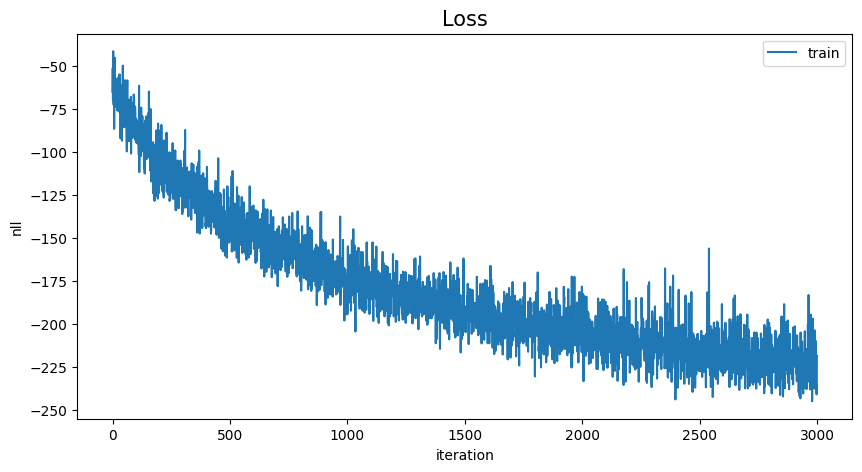

In [9]:

import matplotlib.pyplot as plt
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.savefig("./train.png")
plt.show()


In [10]:

# perform inference
model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

print(forecasts_[0].shape)
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 365, 70)
(1, 100, 365, 70)


In [17]:
# perform evaluate
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts,1).squeeze(0).T
print(f"shape for forecast_median is: {forecast_median.shape}")

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    if item_id >= 2: continue
    print(f"item_id={item_id}, ts={ts}")
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

shape for forecast_median is: (70, 365)
70
item_id=0, ts={'start': Period('2013-01-02', 'D'), 'target': [1.624695, 1.62525, 1.608234, 1.606787, 1.612201, 1.606168, 1.601537, 1.616292, 1.612695, 1.607717, 1.607459, 1.600256, 1.597699, 1.58554, 1.583782, 1.583908, 1.58328, 1.578283, 1.577511, 1.569859, 1.574803, 1.579779, 1.587024, 1.5705, 1.575547, 1.566661, 1.566416, 1.571018, 1.580228, 1.56568, 1.567644, 1.553302, 1.548659, 1.548012, 1.547748, 1.542734, 1.522997, 1.526252, 1.50973, 1.516415, 1.512997, 1.51676, 1.51653, 1.503601, 1.512859, 1.513775, 1.499678, 1.50263, 1.491002, 1.490535, 1.490535, 1.492537, 1.509001, 1.510757, 1.50989, 1.509662, 1.509662, 1.518211, 1.524599, 1.517911, 1.5163, 1.512905, 1.519757, 1.519595, 1.522302, 1.510802, 1.514005, 1.522626, 1.53492, 1.526252, 1.532332, 1.532567, 1.539172, 1.535391, 1.52973, 1.536098, 1.52439, 1.528351, 1.522534, 1.529988, 1.522997, 1.527977, 1.543686, 1.549187, 1.549427, 1.55376, 1.557196, 1.553712, 1.557875, 1.55376, 1.547988, 1.5

In [19]:
print(f"MASE: {np.mean(mase_metrics)}")
print(f"sMAPE: {np.mean(smape_metrics)}")

MASE: 224.9257304365796
sMAPE: 1.5055066970966875


0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]

In [17]:

import matplotlib.dates as mdates
from gluonts.dataset.field_names import FieldName
import matplotlib.pyplot as plt


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = dates
    print(f"index is {index}")
    print(f"length of index: {len(index)}")

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[:-prediction_length],
        multi_variate_test_dataset[ts_index]["target"][mv_index,:],
        label="actual",
    )

    ax.plot(
        index[-2*prediction_length:-prediction_length],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    # ax.fill_between(
    #     index[-2*prediction_length:-prediction_length],
    #     forecasts[ts_index, ..., mv_index].mean(0)
    #     - forecasts[ts_index, ..., mv_index].std(axis=0),
    #     forecasts[ts_index, ..., mv_index].mean(0)
    #     + forecasts[ts_index, ..., mv_index].std(axis=0),
    #     alpha=0.2,
    #     interpolate=True,
    #     label="+/- 1-std",
    # )
    ax.legend()
    fig.autofmt_xdate()
    return fig, ax

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


(0.0, 2.0)

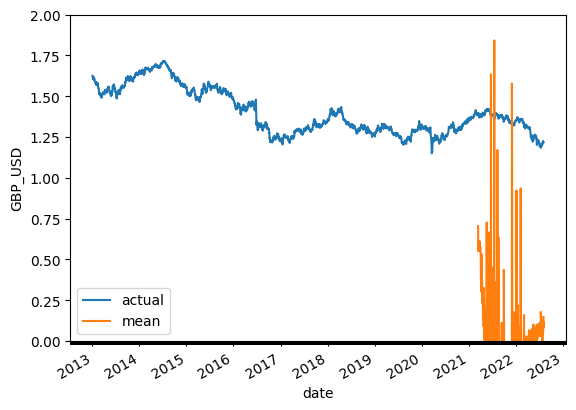

In [25]:
fig, ax = plot(0,0)
ax.set_xlabel('date')
ax.set_ylabel('GBP_USD')
ax.set_ylim(0,2)

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


Text(0, 0.5, 'GBP_EUR')

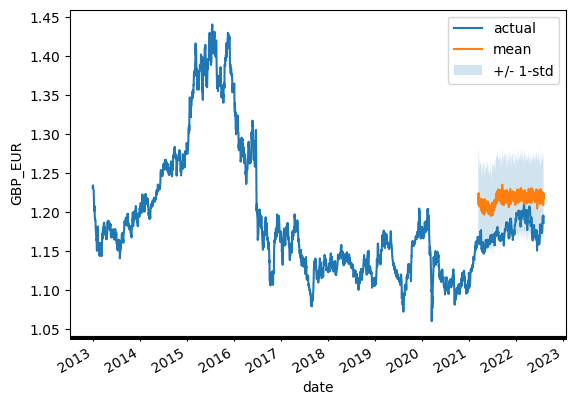

In [42]:
fig, ax = plot(0,1)
ax.set_xlabel('date')
ax.set_ylabel('GBP_EUR')

In [13]:
from accelerate import Accelerator
from torch.optim import AdamW
from evaluate import load
from gluonts.time_feature import get_seasonality
from transformers import InformerConfig, InformerForPrediction
mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

EPOCHS = 10
accelerator = Accelerator()
device = accelerator.device
print(f"available device: {device}")
def train(lr, weight_decay, num_encoder_layers, num_decoder_layers, d_model):
    print(f"-----Start Training Trial for lr={lr}, w_d={weight_decay}, num_encoder_layers={num_encoder_layers}, num_decoder_layers={num_decoder_layers}, d_model={d_model}-----")
    loss_history = []
    config = InformerConfig(
        # in the multivariate setting, input_size is the number of variates in the time series per time step
        input_size=num_of_variates,
        # prediction length:
        prediction_length=prediction_length,
        # context length:
        context_length=prediction_length * 2,
        # lags value copied from 1 week before:
        lags_sequence=[1, 7],
        # we'll add 5 time features ("hour_of_day", ..., and "age"):
        num_time_features=len(time_features) + 1,
        
        # informer params:
        dropout=0.1,
        encoder_layers=num_encoder_layers,
        decoder_layers=num_decoder_layers,
        # project input from num_of_variates*len(lags_sequence)+num_time_features to:
        d_model=d_model,
    )

    from dataloader import create_train_dataloader, create_backtest_dataloader
    train_dataloader = create_train_dataloader(
        config=config,
        freq=freq,
        data=multi_variate_train_dataset,
        batch_size=256,
        num_batches_per_epoch=100,
        num_workers=2,
    )

    test_dataloader = create_backtest_dataloader(
        config=config,
        freq=freq,
        data=multi_variate_test_dataset,
        batch_size=32,
    )

    model = InformerForPrediction(config)
    model.to(device)
    optimizer = AdamW(model.parameters(), lr=lr, betas=(0.9, 0.95), weight_decay=weight_decay)
    model, optimizer, train_dataloader = accelerator.prepare(
        model,
        optimizer,
        train_dataloader,
    )
    model.train()
    for epoch in range(EPOCHS):
        for idx, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            outputs = model(
                static_categorical_features=batch["static_categorical_features"].to(device)
                if config.num_static_categorical_features > 0
                else None,
                static_real_features=batch["static_real_features"].to(device)
                if config.num_static_real_features > 0
                else None,
                past_time_features=batch["past_time_features"].to(device),
                past_values=batch["past_values"].to(device),
                future_time_features=batch["future_time_features"].to(device),
                future_values=batch["future_values"].to(device),
                past_observed_mask=batch["past_observed_mask"].to(device),
                future_observed_mask=batch["future_observed_mask"].to(device),
            )
            loss = outputs.loss

            # Backpropagation
            accelerator.backward(loss)
            optimizer.step()

            loss_history.append(loss.item())
            if idx % 100 == 0:
                print(f"epoch: {epoch}, loss: {loss.item()}")

    # perform the evaluation
    model.eval()

    forecasts_ = []
    for batch in test_dataloader:
        outputs = model.generate(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
        )
        forecasts_.append(outputs.sequences.cpu().numpy())

    forecasts = np.vstack(forecasts_)
    forecast_median = np.median(forecasts,1).squeeze(0).T


    mase_metrics = []
    smape_metrics = []

    for item_id, ts in enumerate(test_dataset):
        if item_id >= 2: continue
        print(f"item_id={item_id}, ts={ts}")
        training_data = ts["target"][:-prediction_length]
        ground_truth = ts["target"][-prediction_length:]
        mase = mase_metric.compute(
            predictions=forecast_median[item_id],
            references=np.array(ground_truth),
            training=np.array(training_data),
            periodicity=get_seasonality(freq),
        )
        mase_metrics.append(mase["mase"])

        smape = smape_metric.compute(
            predictions=forecast_median[item_id],
            references=np.array(ground_truth),
        )
        smape_metrics.append(smape["smape"])

    mase = np.mean(mase_metrics)
    print(f"-----End Training Trial, mase={mase:.1f} for lr={lr}, w_d={weight_decay}, num_encoder_layers={num_encoder_layers}, num_decoder_layers={num_decoder_layers}, d_model={d_model}-----")
    return mase, model, config

available device: cuda


In [22]:
import torch
best_model = None
lrs = [6e-3, 6e-4, 6e-5]
weight_decays = [1e-1, 1e-2]
num_encoders = [6,12]
num_decoders = [4,8]
d_models = [64,128]

least_mase = float('inf')
best_config = None

for lr in lrs:
    for weight_decay in weight_decays:
        for num_encoder_layers in num_encoders:
            for num_decoder_layers in num_decoders:
                for d_model in d_models:
                    try:
                        mase, model, config = train(lr, weight_decay, num_encoder_layers, num_decoder_layers, d_model)
                        if mase < least_mase:
                            print(f"MASE: {mase} is the currently best for [{lr}, {weight_decay}, {num_encoder_layers}, {num_decoder_layers}, {d_model}]")
                            least_mase = mase
                            del best_model
                            best_model = model
                            best_config = config
                        else:
                            del model
                    except Exception as e:
                        print(f"For [{lr}, {weight_decay}, {num_encoder_layers}, {num_decoder_layers}, {d_model}], training failed!, reason: {e}")

-----Start Training Trial for lr=0.006, w_d=0.1, num_encoder_layers=6, num_decoder_layers=4, d_model=64-----
epoch: 0, loss: -58.61406707763672
epoch: 1, loss: -219.54840087890625
epoch: 2, loss: -222.66383361816406
epoch: 3, loss: -206.63165283203125
epoch: 4, loss: -223.871337890625
epoch: 5, loss: -207.36416625976562
epoch: 6, loss: -211.19090270996094
epoch: 7, loss: -221.40557861328125
epoch: 8, loss: -229.24105834960938
epoch: 9, loss: -216.0964813232422
item_id=0, ts={'start': Period('2013-01-02', 'D'), 'target': [1.624695, 1.62525, 1.608234, 1.606787, 1.612201, 1.606168, 1.601537, 1.616292, 1.612695, 1.607717, 1.607459, 1.600256, 1.597699, 1.58554, 1.583782, 1.583908, 1.58328, 1.578283, 1.577511, 1.569859, 1.574803, 1.579779, 1.587024, 1.5705, 1.575547, 1.566661, 1.566416, 1.571018, 1.580228, 1.56568, 1.567644, 1.553302, 1.548659, 1.548012, 1.547748, 1.542734, 1.522997, 1.526252, 1.50973, 1.516415, 1.512997, 1.51676, 1.51653, 1.503601, 1.512859, 1.513775, 1.499678, 1.50263, 1.4

In [24]:
# perform forcasting based on best model

test_dataloader = create_backtest_dataloader(
        config=best_config,
        freq=freq,
        data=multi_variate_test_dataset,
        batch_size=32,
)
# perform inference
best_model.eval()

forecasts_ = []
for batch in test_dataloader:
    outputs = best_model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

forecasts = np.vstack(forecasts_)

In [25]:
df = pd.read_excel('all_data.xlsx', usecols=['Date'])
dates = pd.to_datetime(df['Date'])
dates

0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


(0.0, 2.0)

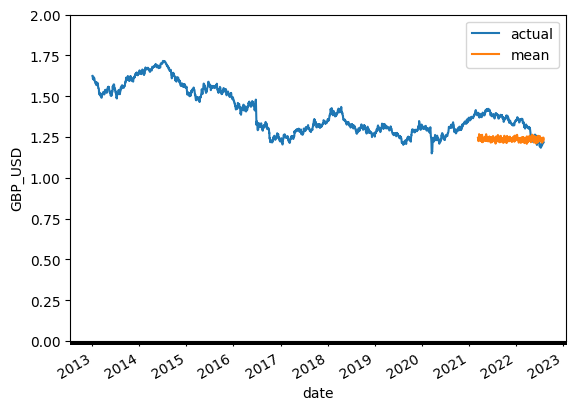

In [26]:
fig, ax = plot(0,0)
ax.set_xlabel('date')
ax.set_ylabel('GBP_USD')
ax.set_ylim(0,2)

index is 0      2013-01-02
1      2013-01-03
2      2013-01-04
3      2013-01-07
4      2013-01-08
          ...    
2863   2023-12-25
2864   2023-12-26
2865   2023-12-27
2866   2023-12-28
2867   2023-12-29
Name: Date, Length: 2868, dtype: datetime64[ns]
length of index: 2868


Text(0, 0.5, 'GBP_EUR')

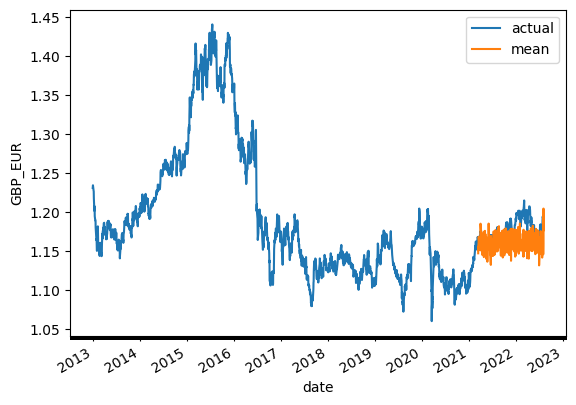

In [27]:
fig, ax = plot(0,1)
ax.set_xlabel('date')
ax.set_ylabel('GBP_EUR')